<center> <H1> Recipe Site Traffic </H1> </center>

## Table of Contents

1. [Project Overview](#1-project-overview)   
   1.1. [Goal](#11-goal)

2. [Dataset](#2-dataset)   
   2.1. [Data Inspection](#21-data-inspection)

   2.2. [Data Transformation](#22-data-transformation)

   2.3. [Data Validation](#23-data-validation)

3. [Exploratory Data Analysis](#3-exploratory-data-analysis)   
   3.1. [Report](#31-report)

4. [Modeling](#4-modeling)   
   4.1. [Model Fitting](#41-model-fitting)

   4.2. [Model Hyperparameter Tuning](#42-model-hyperparameter-tuning)
   
   4.3. [Model Evaluation](#43-model-evaluation)

5. [Business Metrics](#5-business-metrics)
   
6. [Recommendation](#6-recommendation)

# 1. Project Overview

Launched in 2020, Tasty Bytes began as a recipe search tool, helping users make the most of available ingredients they had at home. Now an established company, they provide comprehensive meal plans via subscriptions, ensuring nutritious meals regardless of budget. Premium subscribers enjoy doorstep ingredient delivery. 

They've observed a 40% increase in overall website traffic when a popular recipe is featured on the homepage. However, determining recipe popularity remains a challenge, crucial for boosting subscriptions and company success.

## 1.1 Goal
The goal is to predict recipes driving high website traffic and attain 80% accuracy in predicting high-traffic recipes.

# 2. Dataset

The dataset used for this analysis can be accessed here: `"recipe_site_traffic.csv"`

| Column Name              | Criteria                                                      |
|------------------|--------------------------------------------------------------|
| recipe | Numeric, unique identifier of recipe |
| calories        | Numeric, number of calories |
| carbohydrate       | Numeric, amount of carbohydrates in grams  |
| sugar    | Numeric, amount of sugar in grams    |
| protein      | Numeric, amount of protein in grams     |
| category    | Character, type of recipe. Recipes are listed in one of ten possible groupings (Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal').      |
| servings          | Numeric, number of servings for the recipe            |
| high_traffic | Character, if the traffic to the site was high when this recipe was shown, this is marked with “High”.          |

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# enable inline plotting in Jupyter Notebook
%matplotlib inline

# import libraries for ML
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, plot_confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load dataset
dataset = pd.read_csv('recipe_site_traffic.csv')
print("Data imported successfully")

Data imported successfully


In [3]:
# create a copy of the original dataset
df = dataset.copy()

## 2.1 Data Inspection

In [4]:
# inspect dataframe by printing out the first 5 rows
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [5]:
# check the shape of the dataset i.e. the number of rows and columns
df.shape

(947, 8)

In [6]:
# information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [7]:
# check the datatype counts of the dataset
df.dtypes.value_counts()

float64    4
object     3
int64      1
dtype: int64

In [8]:
# number of unique values in each features
df.nunique()

recipe          947
calories        891
carbohydrate    835
sugar           666
protein         772
category         11
servings          6
high_traffic      1
dtype: int64

In [9]:
# check for duplicated record
df.duplicated().any()

False

In [10]:
# check for missingness in the features
df.isnull().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

In [11]:
# check for percentage of null record
round(df.isnull().sum()/len(df)*100, 2)

recipe           0.00
calories         5.49
carbohydrate     5.49
sugar            5.49
protein          5.49
category         0.00
servings         0.00
high_traffic    39.39
dtype: float64

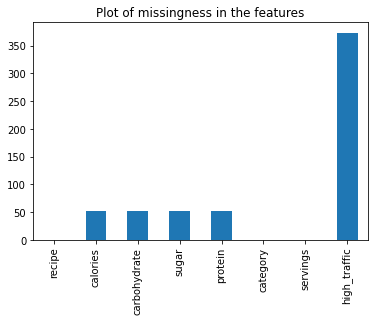

In [12]:
# plot the missingness in the features
df.isnull().sum().plot(kind='bar')
plt.title('Plot of missingness in the features');

## 2.2 Data Transformation

In [13]:
# drop the 'recipe' column as it represents the unique identifier of the recipe and 
# will not be required for modelling
df.drop(['recipe'], axis=1, inplace=True) 

In [14]:
# fill NaNs with column mean in 'calories', 'carbohydrate', 'sugar' and 'protein' columns
cols_with_missing_val = ['calories', 'carbohydrate', 'sugar', 'protein']

# Create a SimpleImputer instance
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on nan_rows and transform it to fill missing values
df[cols_with_missing_val] = imputer.fit_transform(df[cols_with_missing_val])

In [15]:
# Count the occurrences of each unique value in the 'category' column to understand the distribution of recipe categories.
# This helps us gain insights into the most common recipe categories and their prevalence in the dataset.

# Calculate the value counts of category
df['category'].value_counts()

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64

In [16]:
# Some entries have category formatted as 'Chicken Breast', this will be replaced as 'Chicken'
df['category'] = df['category'].str.replace('Chicken Breast', 'Chicken')

In [17]:
# Calculate and display the frequency count of unique values in the 'servings' column.
# This provides insights into the distribution of serving sizes across the dataset.
df['servings'].value_counts()

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

In [18]:
# Replace serving sizes with numeric values in the 'servings' column
# Some entries have serving sizes formatted as '4 as a snack' or '6 as a snack' and will be replaced with numeric value '4' or '6' respectively

df['servings'] = df['servings'].str.replace('4 as a snack', '4')
df['servings'] = df['servings'].str.replace('6 as a snack', '6')

In [19]:
# Convert 'servings' to numeric
df['servings'] = pd.to_numeric(df['servings'], errors='coerce')

In [20]:
# Count the occurrences of each unique value in the 'high_traffic' column
# This provides insight into the distribution of high and non-high traffic recipes
df['high_traffic'].value_counts()

High    574
Name: high_traffic, dtype: int64

In [21]:
# replacing NaN values in high_traffic with 'Low'
df['high_traffic'].fillna("Low", inplace = True)

In [22]:
# Rename the 'high_traffic' column to 'traffic' as it contains traffic variables; 'High' and 'Low'
df.rename(columns={'high_traffic': 'traffic'}, inplace=True)

In [23]:
# plot summary statistics 
df.describe()

,calories,carbohydrate,sugar,protein,servings
count,947.000000,947.000000,947.000000,947.000000,947.000000
mean,435.939196,35.069676,9.046547,24.149296,3.477297
std,440.394131,42.724059,14.270029,35.356020,1.732741
min,0.140000,0.030000,0.010000,0.000000,1.000000
25%,114.410000,9.135000,1.795000,3.465000,2.000000
50%,313.530000,23.170000,5.050000,12.120000,4.000000
75%,576.225000,42.590000,9.285000,28.530000,4.000000
max,3633.160000,530.420000,148.750000,363.360000,6.000000


## 2.3 Data Validation


### Observation
1. The dataset consists of 947 rows and 8 columns.
2. The dataset consists of float64(4), int64(1) and object(3) datatypes respectively.
3. The 'recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'category' and 'high_traffic' features datatype were consistent with the data dictionary while the 'servings' feature was not consistent. It was an object datatype instead of numeric. 
5. The unique variables in the 'category', 'servings' and 'high_traffic' fields were assessed.
6. The 'category' feature has 11 unique variables instead of 10 as provided by the data dictionary. This could be due to inconsistent data entry.
7. The 'servings' feature has 6 unique variables consisting of numeric and object datatypes. This will be formatted so as to be consistent with the data dictionary criteria.
8. Missing values in the 'calories', 'carbohydrate', 'sugar' and 'protein' features were 5.49% respectively and 'high_traffic' field missing value was 39.4%.
9. The 'high_traffic' column contained two features, i.e. 'High' and null values. This translates that the null values represent 'Low' traffic. Also, the column will be renamed to 'traffic'.
10. The summary statistics was obtained.


### Data Cleaning
1. The 'recipe' column was dropped because it represents the unique identifier of the recipe and will not be required for modelling.
2. Missing values in the 'calories', 'carbohydrate', 'sugar' and 'protein' fields were replaced with mean value of respective features.
3. Some entries have serving sizes formatted as '4 as a snack' or '6 as a snack' were replaced with the numeric value '4' or '6' respectively. Thereafter, the 'servings' feature was converted to numeric.
4. Some entries have category formatted as 'Chicken Breast' and was replaced with the value 'Chicken'.
5. Rows that contain null values in 'high_traffic' field were replaced with 'Low'.
6. The 'high_traffic' column was renamed to 'traffic'.

# 3. Exploratory Data Analysis

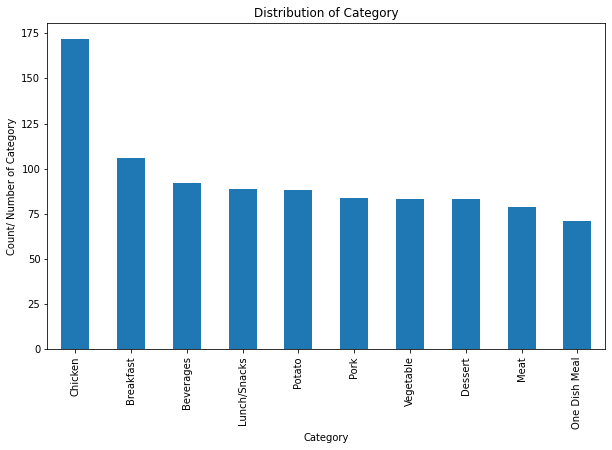

In [24]:
# visualize the category distribution

plt.figure(figsize=(10, 6))
df['category'].value_counts().plot(kind='bar')
plt.title('Distribution of Category')
plt.xlabel('Category')
plt.ylabel('Count/ Number of Category')
plt.xticks(rotation=90)
plt.show()

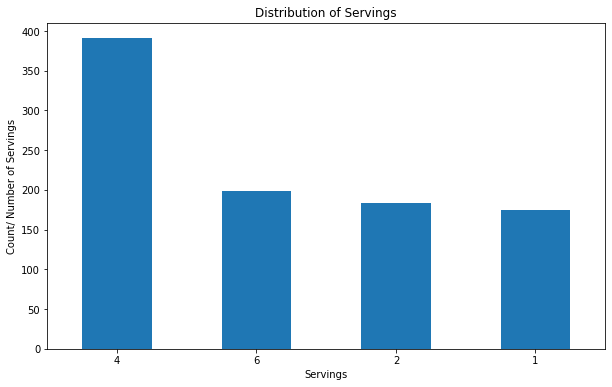

In [25]:
# visualize the servings distribution

plt.figure(figsize=(10, 6))
df['servings'].value_counts().plot(kind='bar')
plt.title('Distribution of Servings')
plt.xlabel('Servings')
plt.ylabel('Count/ Number of Servings')
plt.xticks(rotation=0)
plt.show()

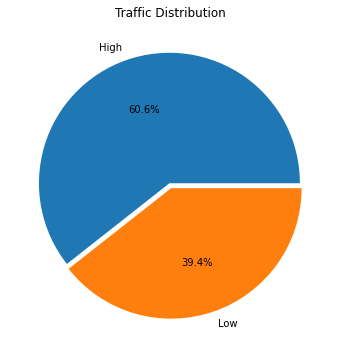

In [26]:
# compute percentage of traffic
df['traffic'].value_counts().plot.pie(explode= [0.02, 0.02], autopct = '%1.1f%%', figsize=(10,6), ylabel='')
plt.title('Traffic Distribution');

<Figure size 720x432 with 0 Axes>

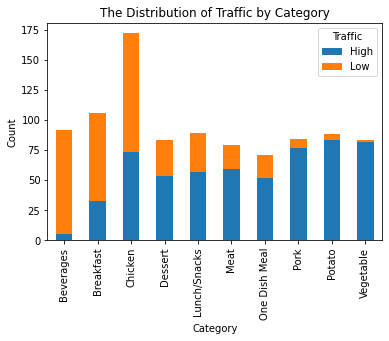

In [27]:
# Create a cross-tabulation of 'category' and 'traffic'
ct = pd.crosstab(df['category'], df['traffic'])

# Create a stacked bar chart using Seaborn
plt.figure(figsize=(10, 6))
ct.plot(kind='bar', stacked=True)
plt.title('The Distribution of Traffic by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Traffic')
plt.show()

<Figure size 720x432 with 0 Axes>

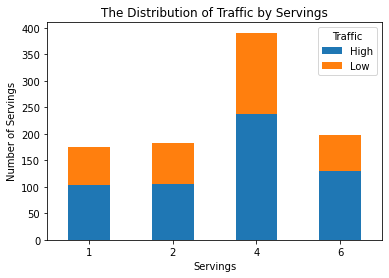

In [28]:
# Pivot the data to get counts of each combination
pivot_df = df.groupby(['servings', 'traffic']).size().unstack()

# Plot the stacked bar chart
plt.figure(figsize=(10, 6))
pivot_df.plot(kind='bar', stacked=True)
plt.title('The Distribution of Traffic by Servings')
plt.xlabel('Servings')
plt.ylabel('Number of Servings')
plt.legend(title='Traffic')
plt.xticks(rotation=0)
plt.show()

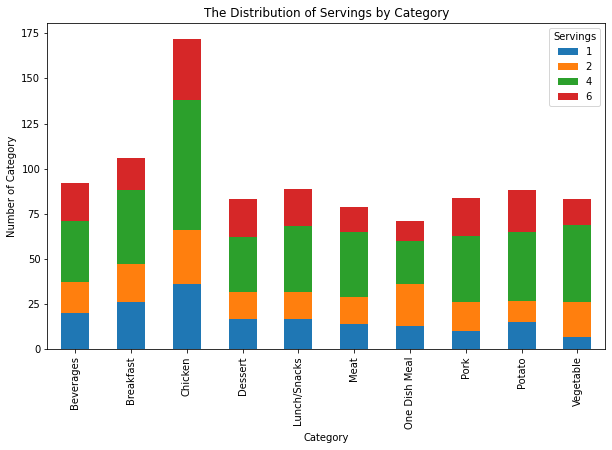

In [29]:
# Create a crosstab to get counts for each combination of category and servings
crosstab_data = pd.crosstab(df['category'], df['servings'])

# Plot a stacked bar chart
ax = crosstab_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('The Distribution of Servings by Category')
plt.xlabel('Category')
plt.ylabel('Number of Category')
plt.xticks(rotation=90)
plt.legend(title='Servings')
plt.show()

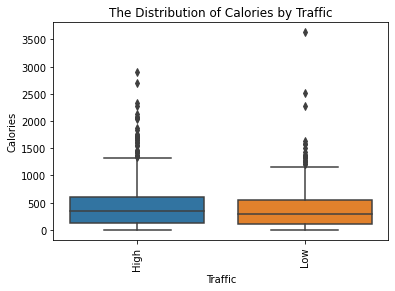

In [30]:
# Boxplot Analysis: Relationship between Calories and Category
sns.boxplot(x='traffic', y='calories', data=df)
plt.title("The Distribution of Calories by Traffic")
plt.xlabel('Traffic')
plt.ylabel('Calories')
plt.xticks(rotation=90)
plt.show()

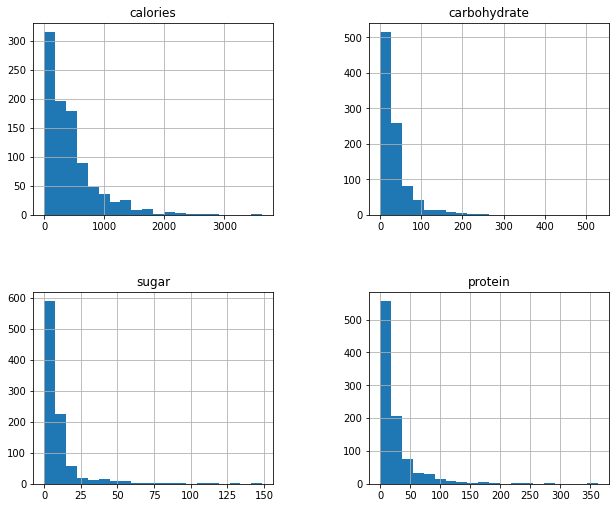

In [31]:
# Histogram plot of numerical features shows the skewness of the data
feats_to_drop = ['category', 'servings', 'traffic']
df.drop(columns=feats_to_drop).hist(grid=True, layout=(2,2), bins=20)
plt.subplots_adjust(left=0.1,bottom=0.1,  right=0.9, top=0.9,  wspace=0.4, hspace=0.4)  
plt.gcf().set_size_inches(10,8)
plt.show()

In [32]:
# for modeling purpose, encode categorical variables to numeric using Ordinal Encoder
cat_features = ['category']
category_encoder = OrdinalEncoder()
df[cat_features] = category_encoder.fit_transform(df[cat_features])

In [33]:
# replace 'High' with 1 and 'Low' with 0 in 'traffic' column
df['traffic'] = df['traffic'].apply(lambda x: 1 if x == 'High' else 0)

In [34]:
# check if all columns are numeric
assert df.dtypes.apply(pd.api.types.is_numeric_dtype).all()

print("All columns are in numeric datatype.")

All columns are in numeric datatype.


In [35]:
# create explanatory variable (X) and response variable (y)
X = df.drop(columns='traffic')
y = df['traffic']

In [36]:
# split data into train and test sets - 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
#  assert data split to avoid leakage
print(len(X_train) + len(X_test) == len(X))
print(len(y_train) + len(y_test) == len(y))

True
True


In [38]:
# normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 3.1 Report

- Examining the pie chart, it's evident that 60.6% of recipes result in high traffic, while 39.4% yield low traffic.
- Chicken is the most frequently ordered category, with Breakfast being the next popular choice, while One Dish Meal is the least preferred. This suggests that chicken-based recipes tend to provide higher calorie content. Hence, the more calories a food has, the higher the chance of selecting the food thereby leading to high traffic and this is due to their high nutritional contents.  
- Categories like Potato, Vegetable, and Pork are associated with high traffic. 
- The boxplot reveals that the more calories a food has, the higher the chance of selecting the food thereby leading to high traffic.
- In terms of servings, '4' has the highest traffic frequency, followed by '6', '2', and '1'. This suggests subscribers live an above-average lifestyle, opting for moderate food consumption to maintain health. 


- The numerical features are right skewed hence the data will be normalized for machine learning.
- The categorical variables were encoded to numeric as this is necessary for machine learning.
- The explanatory variable (X) and response variable (y) were created and splitted into train and test set.
- The train and test was normalized so as to keep all features within the same distance metric.

# 4. Modeling

## 4.1 Model Fitting

As the target variable is 'traffic,' categorized as High (1) or Low (0), this presents a classification task. </br> It involves supervised learning, where the program learns from training data to predict new instances. </br> For modeling, five classification models namely, Logistic Regression, Decision Tree, Random Forest, XGBoost and Gradient Boosting models will be employed to make predictions.

In [39]:
# instantiate models
modelclasses = {'LogisticReg': LogisticRegression(random_state=42),
                'DecisionTree': DecisionTreeClassifier(random_state=42),
                'RandomForest': RandomForestClassifier(random_state=42),
                'XGBoost': XGBClassifier(random_state=42),
                'GradientBoosting': GradientBoostingClassifier(random_state=42)
             }

In [40]:
# Iteration of models

# create a list to store model results
acc_scores = []
f1_scores = []

for model_name, model_method in modelclasses.items():
       
    # fit model to training data
    model_method.fit(X_train, y_train)
    
    # predict the outcomes on the test set
    y_pred = model_method.predict(X_test)
    
    # append accuracy evaluation metric for the model to the list 
    acc_scores.append(round(accuracy_score(y_test, y_pred),2))
    
    # append R2 score evaluation metric for the model to the list
    f1_scores.append(round(f1_score(y_test, y_pred, pos_label='positive', average='macro'),2))
    
# create a dataframe to store the results
cla_results = pd.DataFrame({"Model":modelclasses.keys(), "Accuracy Score": acc_scores, "F1 Score": f1_scores})
cla_results

,Model,Accuracy Score,F1 Score
0,LogisticReg,0.76,0.75
1,DecisionTree,0.65,0.64
2,RandomForest,0.71,0.68
3,XGBoost,0.72,0.70
4,GradientBoosting,0.75,0.73


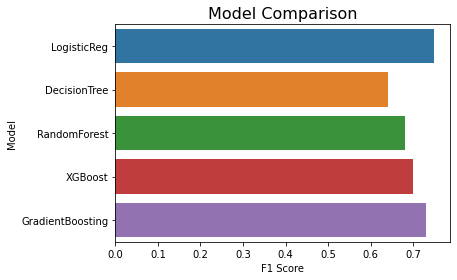

In [41]:
# plot the Accuracy Score 
plt.ylabel('Model')
plt.xlabel('')
plt.title('Model Comparison', fontsize=16)
sns.barplot(x=cla_results['F1 Score'], y=cla_results.Model)
plt.show()

In [42]:
# Model Evaluation
def evaluation_metrics_func(y_test, y_pred):
    
    print('Evaluation metric results:-')
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred):.2f}')
    print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
    print('Classification Report : \n', classification_report(y_test, y_pred))

## 4.2 Model Hyperparameter Tuning

The Logistic Regression classifier stood out with strong accuracy and F1 scores. We'll conduct hyperparameter tuning to delve deeper into the capabilities of this model.

Hyperparameter tuning involves discovering the optimal settings that influence how a machine learning model works, aiming to enhance its performance for a given task. We'll employ the Grid Search technique, where a predefined range of hyperparameter values is evaluated exhaustively to find the best combination.

In [43]:
# Hyperparameter tuning for Logistic Regression using GridSearchCV
grid_search = GridSearchCV(LogisticRegression(random_state=42),
                 param_grid = {
                              'C': [0.01, 0.1, 1.0, 10.0],           # Inverse of regularization strength
                              'penalty': ['l1', 'l2'],               # Regularization type ('l1' or 'l2')
                              'solver': ['liblinear', 'lbfgs'],      # Optimization algorithm
                              'max_iter': [100, 200, 300]            # Maximum number of iterations
                               }, cv=5,                              # Cross-validation folds
                                  scoring='accuracy',                # The metric to optimize
                                  verbose=1                          # Verbosity level
                                            )


# Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)

best_params=grid_search.best_params_

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n", grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n", best_params)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
 Results from Random Search 

 The best estimator across ALL searched params:
 LogisticRegression(random_state=42)

 The best score across ALL searched params:
 0.7635935866155454

 The best parameters across ALL searched params:
 {'C': 1.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


Evaluation metric results:-
Accuracy Score: 0.76
F1 Score: 0.80
Confusion Matrix: 
 [[54 23]
 [23 90]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.70      0.70      0.70        77
           1       0.80      0.80      0.80       113

    accuracy                           0.76       190
   macro avg       0.75      0.75      0.75       190
weighted avg       0.76      0.76      0.76       190

Confusion Matrix:



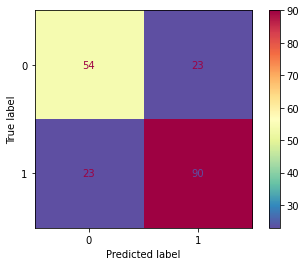

In [44]:
# Build Logistic Regression Classifier Model
model = LogisticRegression(C=best_params["C"], 
                               penalty=best_params["penalty"], 
                               solver=best_params['solver'],
                               max_iter=best_params['max_iter']
                              )

# fit model
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# computing the evaluation metrics
evaluation_metrics_func(y_test, y_pred)
print(f'Confusion Matrix:\n')
plot_confusion_matrix(model, X_test, y_test, cmap='Spectral_r');

In [45]:
# Get feature weights (coefficients)
feature_weights = model.coef_[0]

# Print feature weights
print("Feature Weights:")
for feature, weight in zip(X.columns, feature_weights):
    print(f"{feature}: {weight:.4f}")

Feature Weights:
calories: 0.1459
carbohydrate: 0.7909
sugar: -0.0753
protein: 0.3626
category: 4.2452
servings: 0.0980


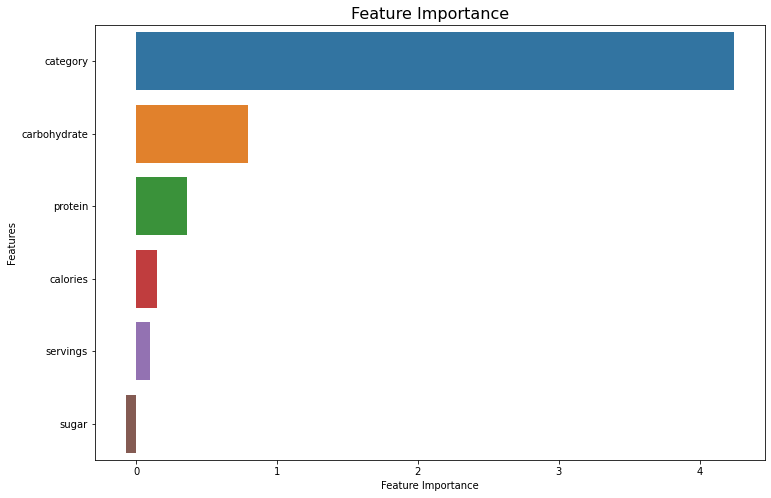

In [46]:
# create a dataframe of feature weight
feat_imp_ = pd.DataFrame(feature_weights, X.columns, columns=["Feature Importance"]).sort_values(by="Feature Importance", ascending=False)

# plot feature weights
plt.figure(figsize=(12,8))
plt.ylabel('Features')
plt.xlabel('')
plt.title('Feature Importance', fontsize=16)
sns.barplot(x=feat_imp_['Feature Importance'], y=feat_imp_.index)
plt.show()

## 4.3 Model Evaluation

1. The Logistic Regression classifier showcased higher accuracy, as demonstrated by the accuracy score and F1 score evaluations.
2. Utilizing the Logistic Regression model, our aim was to uncover the main catalysts for increased website traffic. The 'category' attribute surfaced as the most influential factor, trailed by carbohydrate and protein, as illustrated by feature importance plot. Notably, recipes with elevated sugar content were linked to reduced traffic, possibly due to the maintenance of healthy lifestyle by subscribers.

# 5. Business Metrics

As our objective is to predict recipe popularity with an 80% accuracy rate while minimizing the presentation of unpopular recipes, the model demonstrates that food categories with substantial carbohydrate content, where protein constitutes half of the carbohydrate ratio, display considerable attractiveness and frequently align with increased website traffic. 
Notably, recipes with elevated sugar content were linked to reduced traffic, possibly due to the maintenance of healthy lifestyle by subscribers.

# 6. Recommendation

I would recommend that Tasty Bytes should do the following in order to boost revenue:


- Using key metrics to monitor whether there is a strong sign to see the elevated website traffic.
- Cost per serving should be provided on the website for visitors to make choice.
- Display food categories with substantial carbohydrate content and protein more often.
- Display food with high calorie contents and nutritional value. 
- Data Collection for in-depth analysis
    - Operational area and customer demographics
    - Time to make and cost per serving `($)` as these features might influence customer's decision.